In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path

['/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/home/blessyantony/.local/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/blessyantony/.ipython',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../..']

In [2]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.metrics import roc_curve, accuracy_score, f1_score, auc, precision_recall_curve
from statistics import mean

from src.utils import utils, evaluation_utils, visualization_utils

In [44]:
tf_output_file_path = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_idv/20240613/host_multi/few_shot_learning/fsl_idv_uniref90viridae_msl2048_transformer-l_6-h_8-d_1024-lr1e-4_classwise_auprc.csv")
virprobert_output_file_path = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_idv/20240614/host_multi/few_shot_learning/3_way5shot_q_all_fsl_idv_uniref90viridae_msl2048_virprobert_classwise_auprc.csv")
dataset_file_path = os.path.join(os.getcwd(), "..","..", "..", "input/data/uniref90/20240131/uniref90_viridae_embl_hosts_pruned_metadata_species_vertebrates_w_seq_idv.csv")
virprobert_output_scores_file_path = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_idv/20240614/host_multi/few_shot_learning/3_way5shot_q_all_fsl_idv_uniref90viridae_msl2048_virprobert_output.csv")

output_file_paths = {
    #"TF": tf_output_file_path,
    "VirProBERT": virprobert_output_file_path
}

In [45]:
def read_output_df(output_file_paths):
    dfs = []
    for model, output_file_path in output_file_paths.items():
        df = pd.read_csv(output_file_path, index_col=0)
        df = df[df["itr"].isin(range(3))]
        df["model"] = model
        dfs.append(df)
    return pd.concat(dfs)

def compute_class_distribution(df, label_col, format=False):
    labels_counts = df[label_col].value_counts()
    n = labels_counts.sum()
    labels_counts = labels_counts / n * 100
    labels_counts = labels_counts.to_dict()
    if format:
        labels_counts = {k: f"{k} ({v:.4f}%)" for k, v, in labels_counts.items()}
    return labels_counts



In [46]:
df = read_output_df(output_file_paths)
scores_output_df = pd.read_csv(virprobert_output_scores_file_path, index_col=0)
dataset_df = pd.read_csv(dataset_file_path)

In [47]:
metadata_formatted = compute_class_distribution(scores_output_df[scores_output_df["itr"]==0], "y_true", format=True)
metadata_formatted

{'Homo sapiens': 'Homo sapiens (99.4632%)',
 'Macaca mulatta': 'Macaca mulatta (0.3388%)',
 'Felis catus': 'Felis catus (0.0665%)',
 'Cercocebus atys': 'Cercocebus atys (0.0658%)',
 'Puma concolor': 'Puma concolor (0.0092%)',
 'Mandrillus sphinx': 'Mandrillus sphinx (0.0072%)',
 'Cercopithecus nictitans': 'Cercopithecus nictitans (0.0071%)',
 'Macaca nemestrina': 'Macaca nemestrina (0.0058%)',
 'Mandrillus leucophaeus': 'Mandrillus leucophaeus (0.0048%)',
 'Colobus guereza': 'Colobus guereza (0.0043%)',
 'Cercocebus torquatus': 'Cercocebus torquatus (0.0041%)',
 'Cercopithecus cephus': 'Cercopithecus cephus (0.0041%)',
 'Cercopithecus aethiops': 'Cercopithecus aethiops (0.0034%)',
 'Cercopithecus neglectus': 'Cercopithecus neglectus (0.0034%)',
 'Cercopithecus solatus': 'Cercopithecus solatus (0.0029%)',
 'Panthera leo': 'Panthera leo (0.0028%)',
 'Chlorocebus tantalus': 'Chlorocebus tantalus (0.0024%)',
 'Chlorocebus sabaeus': 'Chlorocebus sabaeus (0.0024%)',
 'Cercopithecus mona': 'C

In [48]:
metadata_unformatted = compute_class_distribution(scores_output_df[scores_output_df["itr"]==0], "y_true", format=False)
metadata_unformatted

{'Homo sapiens': 99.46318958889138,
 'Macaca mulatta': 0.33880152573085187,
 'Felis catus': 0.06647574959837567,
 'Cercocebus atys': 0.06575318710274115,
 'Puma concolor': 0.00915245827803723,
 'Mandrillus sphinx': 0.007225624956345182,
 'Cercopithecus nictitans': 0.007118578660695624,
 'Macaca nemestrina': 0.0057804999650761454,
 'Mandrillus leucophaeus': 0.004817083304230122,
 'Colobus guereza': 0.00428185182598233,
 'Cercocebus torquatus': 0.004121282382507993,
 'Cercopithecus cephus': 0.004067759234683214,
 'Cercopithecus aethiops': 0.003371958312961085,
 'Cercopithecus neglectus': 0.003371958312961085,
 'Cercopithecus solatus': 0.0028902499825380727,
 'Panthera leo': 0.002809965260800904,
 'Chlorocebus tantalus': 0.002408541652115061,
 'Chlorocebus sabaeus': 0.002355018504290282,
 'Cercopithecus mona': 0.0020071180434292173}

In [49]:
classes = list(metadata_unformatted.keys())
classes

['Homo sapiens',
 'Macaca mulatta',
 'Felis catus',
 'Cercocebus atys',
 'Puma concolor',
 'Mandrillus sphinx',
 'Cercopithecus nictitans',
 'Macaca nemestrina',
 'Mandrillus leucophaeus',
 'Colobus guereza',
 'Cercocebus torquatus',
 'Cercopithecus cephus',
 'Cercopithecus aethiops',
 'Cercopithecus neglectus',
 'Cercopithecus solatus',
 'Panthera leo',
 'Chlorocebus tantalus',
 'Chlorocebus sabaeus',
 'Cercopithecus mona']

In [50]:
import math

def get_uniformly_divided_position_bins(positions, n_bins):
    bin_width = math.floor(len(positions)/n_bins)
    bins = []
    start = 0
    for i in range(n_bins):
        end = start + bin_width
        bins.append(positions[start:end])
        start = end
    return bins

<Figure size 432x288 with 0 Axes>

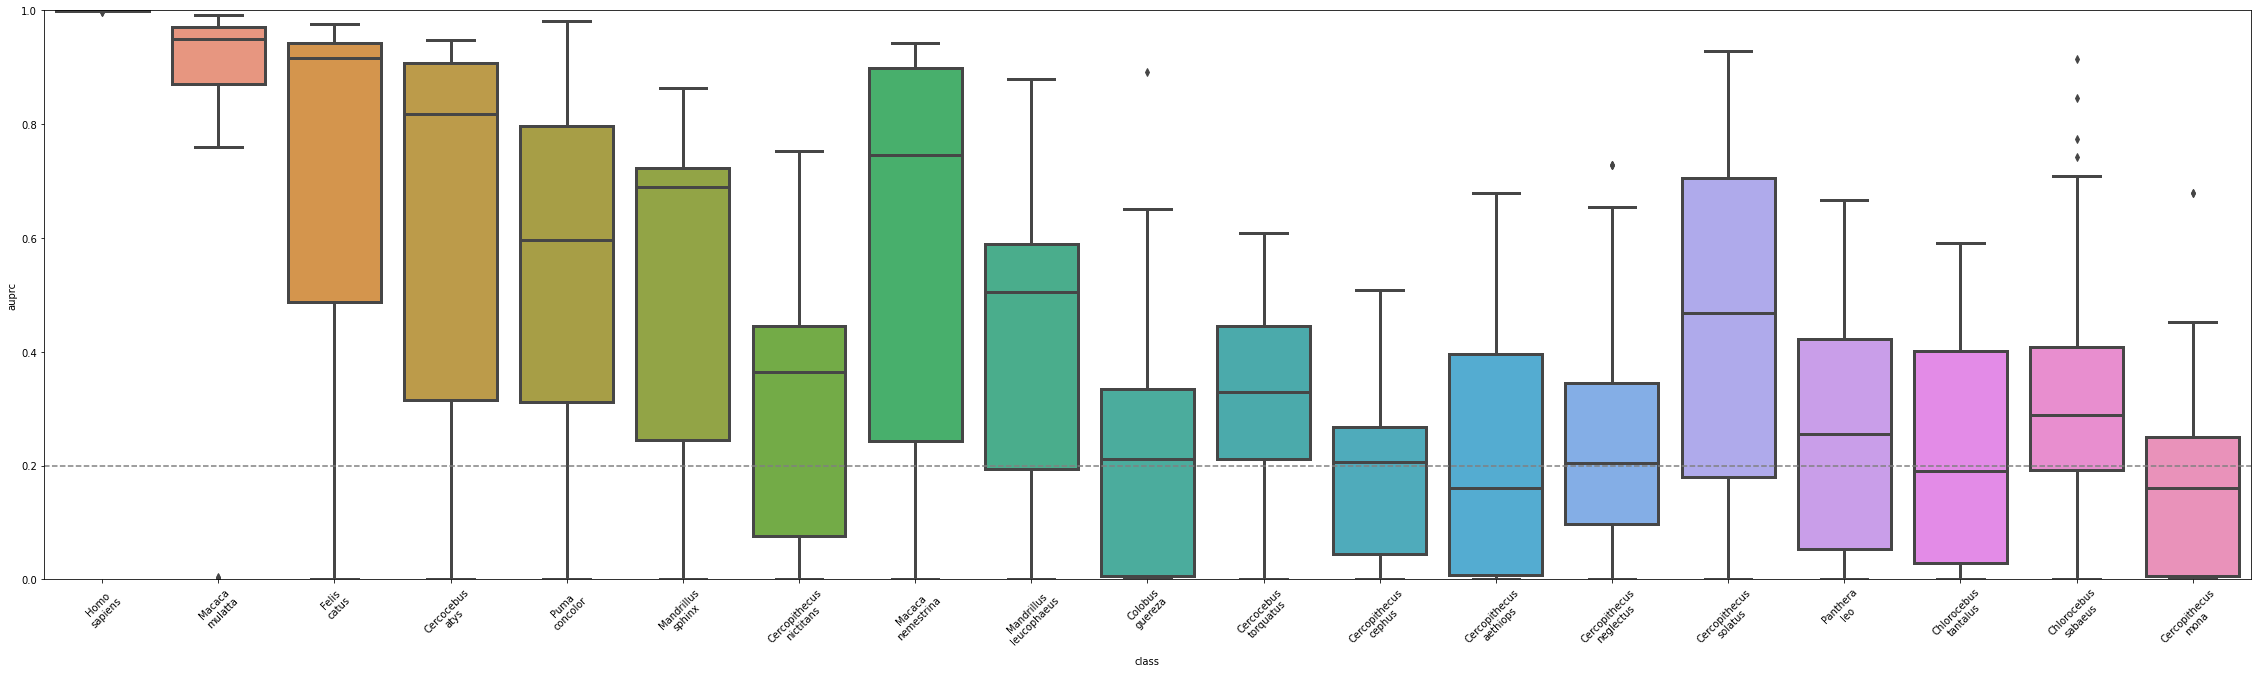

In [17]:
plt.rcParams['figure.autolayout'] = True
plt.clf()
fig, axs = plt.subplots(1, 1, figsize=(32, 10), sharey=True)
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 28
plt.rcParams.update({'font.size': 28})


bins = get_uniformly_divided_position_bins(list(classes), 1)

for i in range(1):
    sns.boxplot(data=df[df["class"].isin(bins[i])],  y="auprc", x="class", ax=axs, orient="v", 
                linewidth=3, order=classes)
    #sns.stripplot(data=df[df["class"].isin(bins[i])], x="class", y="auprc", ax=axs[i])
    visualization_utils.wrap_ticklabels(axs, axis="x")
    axs.tick_params(axis='x', rotation=45)
    axs.set_ylim(0, 1)
    axs.axhline(0.2, color="gray", linestyle="--")

plt.show()

<Figure size 432x288 with 0 Axes>

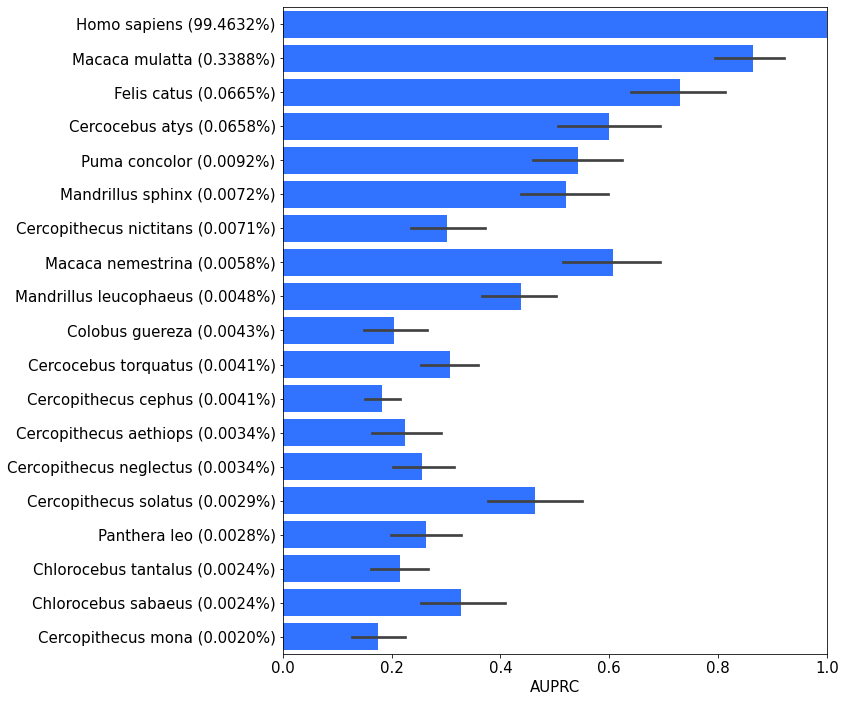

In [58]:
plt.rcParams['figure.autolayout'] = True
plt.clf()
fig, axs = plt.subplots(1, 1, figsize=(12, 10), sharey=True)
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams.update({'font.size': 15})

df = read_output_df(output_file_paths)
df = df.replace({"class": metadata_formatted})
# df.head()
classes = list(metadata_formatted.values())
bins = get_uniformly_divided_position_bins(list(classes), 1)

for i in range(1):
    sns.barplot(data=df[df["class"].isin(bins[i])],  x="auprc", y="class", ax=axs, orient="h", facecolor="#3172FF",
                linewidth=3, order=classes)
    #sns.stripplot(data=df[df["class"].isin(bins[i])], x="class", y="auprc", ax=axs[i])
    # visualization_utils.wrap_ticklabels(axs, axis="y")
    #axs.tick_params(axis='x', rotation=45)
    axs.set_xlim(0, 1)
    axs.set_ylabel("")
    axs.set_xlabel("AUPRC")
    # axs.axhline(0.2, color="gray", linestyle="--")

visualization_utils.view(os.path.join(os.getcwd(), "..","..", "..", "output/visualization/temp/few_shot_learning/fsl_idv_uniref90viridae_msl2048.pdf"))

In [33]:
df

,class,auprc,itr,model
0,Cercopithecus aethiops (0.0034%),0.333980,0,VirProBERT
1,Cercopithecus cephus (0.0041%),0.200300,0,VirProBERT
2,Colobus guereza (0.0043%),0.213928,0,VirProBERT
3,Cercopithecus mona (0.0020%),0.452841,0,VirProBERT
4,Macaca nemestrina (0.0058%),0.898216,0,VirProBERT
...,...,...,...,...
295,Colobus guereza (0.0043%),0.070476,2,VirProBERT
296,Felis catus (0.0665%),0.945069,2,VirProBERT
297,Cercopithecus neglectus (0.0034%),0.000049,2,VirProBERT
298,Homo sapiens (99.4632%),0.999975,2,VirProBERT


In [52]:
df = pd.read_csv(output_file_path, index_col=0)

NameError: name 'output_file_path' is not defined

In [22]:
df

,Cercocebus torquatus,Homo sapiens,Puma concolor,y_true,Cercopithecus solatus,Macaca mulatta,Mandrillus sphinx,Cercopithecus nictitans,Cercocebus atys,Macaca nemestrina,Felis catus,Mandrillus leucophaeus,itr
0,0.885559,0.110253,0.004188,Cercocebus torquatus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,0.374630,0.092263,0.533107,Cercocebus torquatus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,0.056965,0.208990,0.734045,Cercocebus torquatus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,0.736625,0.202603,0.060772,Cercocebus torquatus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,0.990599,0.007073,0.002327,Cercocebus torquatus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.012537,NaN,NaN,Mandrillus leucophaeus,NaN,NaN,NaN,0.096752,NaN,NaN,NaN,0.890712,4
2996,0.028757,NaN,NaN,Mandrillus leucophaeus,NaN,NaN,NaN,0.776685,NaN,NaN,NaN,0.194557,4
2997,0.290067,NaN,NaN,Mandrillus leucophaeus,NaN,NaN,NaN,0.133301,NaN,NaN,NaN,0.576631,4
2998,0.021119,NaN,NaN,Mandrillus leucophaeus,NaN,NaN,NaN,0.040057,NaN,NaN,NaN,0.938824,4


In [37]:
itr_col = "itr"
experiment_col = "experiment"
y_true_col = "y_true"
def class_wise_auprc_analysis(df, classes, figure_output_filepath=None):
    auprc_results = []
    itrs = df[itr_col].unique()
    for itr in itrs:
        df_itr = df[df[itr_col] == itr]
        _, auprcs_df = evaluation_utils.compute_class_auprc(df_itr, y_pred_columns=classes, y_true_col=y_true_col)
        auprcs_df["model"] = model
        auprcs_df["itr"] = itr
        auprc_results.append(auprcs_df)
    metadata = utils.compute_class_distribution(df_itr, y_true_col, format=False)
    metadata_formatted = utils.compute_class_distribution(df_itr, y_true_col, format=True)
    metadata_sorted = {}
    for k, v in metadata.items():
        metadata_sorted[metadata_formatted[k]] = v

    auprc_results_df = pd.concat(auprc_results, ignore_index=True)
    auprc_results_df.replace({"class":metadata_formatted}, inplace=True)
    
    FIGURE_CONFIG = {
        "figsize": (15, 10),
        "xtick.labelsize": 20,
        "ytick.labelsize": 20    
    }

    visualization_utils.pre_plot_config(FIGURE_CONFIG)
    ax = sns.lineplot(data=auprc_results_df, x="class", y="auprc", hue="model", markers=True, dashes=False)
    plt.draw()
    
    ax.set_ylim(0, 1)
    ax.set_ylabel("AUPRC", size=22)
    ax.set_xlabel("", size=22, labelpad=2)
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=5, title=None, frameon=False)
    plt.setp(ax.get_legend().get_texts(), fontsize=16)
    visualization_utils.wrap_xticklabels(ax)
    # visualization_utils.view(figure_output_filepath)
    plt.show()
    return auprc_results_df


# compute class-wise auprc in given df
def compute_class_auprc(df, y_pred_columns, y_true_col):
    pr_curves = []
    auprcs = []
    for y_pred_column in y_pred_columns:
        class_df = df.
        precision, recall, _ = precision_recall_curve(y_true=df[y_true_col].values, probas_pred=df[y_pred_column].values, pos_label=y_pred_column)
        pr_curves.append(pd.DataFrame({"precision": precision, "recall": recall, "class": y_pred_column}))
        auprcs.append({"class": y_pred_column, "auprc": auc(recall, precision)})
    return pd.concat(pr_curves, ignore_index=True), pd.DataFrame(auprcs)

In [38]:
classes = df.columns

In [39]:
classes = ['Cercocebus torquatus', 'Homo sapiens', 'Puma concolor',
       'Cercopithecus solatus', 'Macaca mulatta', 'Mandrillus sphinx',
       'Cercopithecus nictitans', 'Cercocebus atys', 'Macaca nemestrina',
       'Felis catus', 'Mandrillus leucophaeus']

In [42]:
df.dropna(axis=0, subset=["Cercocebus torquatus"])
df.dropna(axis=1)

,Cercocebus torquatus,Homo sapiens,Puma concolor,y_true,Cercopithecus solatus,Macaca mulatta,Mandrillus sphinx,Cercopithecus nictitans,Cercocebus atys,Macaca nemestrina,Felis catus,Mandrillus leucophaeus,itr
0,0.885559,0.110253,0.004188,Cercocebus torquatus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,0.374630,0.092263,0.533107,Cercocebus torquatus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,0.056965,0.208990,0.734045,Cercocebus torquatus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,0.736625,0.202603,0.060772,Cercocebus torquatus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,0.990599,0.007073,0.002327,Cercocebus torquatus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.012537,NaN,NaN,Mandrillus leucophaeus,NaN,NaN,NaN,0.096752,NaN,NaN,NaN,0.890712,4
2996,0.028757,NaN,NaN,Mandrillus leucophaeus,NaN,NaN,NaN,0.776685,NaN,NaN,NaN,0.194557,4
2997,0.290067,NaN,NaN,Mandrillus leucophaeus,NaN,NaN,NaN,0.133301,NaN,NaN,NaN,0.576631,4
2998,0.021119,NaN,NaN,Mandrillus leucophaeus,NaN,NaN,NaN,0.040057,NaN,NaN,NaN,0.938824,4


In [40]:
class_wise_auprc_analysis(df, classes, figure_output_filepath=None)

ValueError: Input contains NaN.